In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import obspy
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
import h5py
import seaborn as sns 

In [94]:
from math import log, ceil, floor
def closest_power(x, power=8):
    possible_results = floor(log(x, power)), ceil(log(x, power))
    return min(possible_results, key= lambda z: abs(x-power**z))

def load_data(root_dir, h5_file, normalize=True, constrain_size=True):
    filepath = f'{root_dir}{h5_file}'
    event_types = ''
    with h5py.File(filepath, "r") as f:
        X = f['X'][:]
        labels = f['label'][:]
        windows = f['window'][:]
        ids = f['id'][:]
       
    if constrain_size:
        power = closest_power(X.shape[1], power=2)
        max_size = 2**power
        if max_size > X.shape[1]:
            power -= 1
            max_size = 2**power
        print(max_size, power, X.shape)
        X = X[:,:max_size,:]
        labels = labels[:,:max_size,:]
    
    if normalize:
        min_per_entry = np.expand_dims(np.min(labels[:,:,0], axis=1), axis=1)
        #print('min_per_entry', min_per_entry.shape)
        X[:,:,0] += abs(min_per_entry)
        labels[:,:,0] += abs(min_per_entry)
        normalization_factor = np.expand_dims(np.max(abs(labels[:,:,0]), axis=1), axis=1)
        X[:,:,0] /= normalization_factor
        labels[:,:,0] /= normalization_factor
        
        if X.shape[-1] > 1:
            min_per_entry = np.expand_dims(np.min(X[:,:,1], axis=1), axis=1)
            X[:,:,1] += abs(min_per_entry)
            normalization_factor = np.expand_dims(np.max(abs(X[:,:,1]), axis=1), axis=1)
            X[:,:,1] /= normalization_factor
        
    return X, labels, windows, event_types, ids


root_dir = '/adhocdata/infrasound/2023_ML_balloon/data/'
h5_file  = 'training_waveform_dataset.h5'
X_training, labels_training, windows_training, _, ids_training = load_data(root_dir, h5_file, normalize=True)
h5_file  = 'testing_waveform_dataset.h5'
X_testing, labels_testing, windows_testing, _, ids_testing = load_data(root_dir, h5_file)
h5_file  = 'validation_waveform_dataset.h5'
X_validation, labels_validation, windows_validation, _, ids_validation = load_data(root_dir, h5_file)

256 8 (2437, 256, 1)
256 8 (517, 256, 1)
256 8 (1552, 256, 1)


In [95]:
obs_time = pd.to_datetime('2019-07-22T16:27:26Z')

filter_dates = pd.DataFrame()
filter_dates['ids'] = ids_testing
filter_dates['starttime'] = pd.to_datetime(windows_testing[:,0].astype(str))
filter_dates['endtime'] = pd.to_datetime(windows_testing[:,1].astype(str))
#filter_dates['ids'] = ids_validation
#filter_dates['starttime'] = pd.to_datetime(windows_validation[:,0].astype(str))
#filter_dates['endtime'] = pd.to_datetime(windows_validation[:,1].astype(str))
#print(filter_dates)
#print(filter_dates['starttime'].min(), filter_dates['starttime'].max())
print(filter_dates.loc[(filter_dates.starttime<=obs_time)&(filter_dates.endtime>=obs_time)].sort_values(by='starttime'))

                 ids                        starttime  \
386  b'Tortoise-204' 2019-07-22 16:27:25.828400+00:00   

                             endtime  
386 2019-07-22 16:28:17.028400+00:00  


<IPython.core.display.Javascript object>


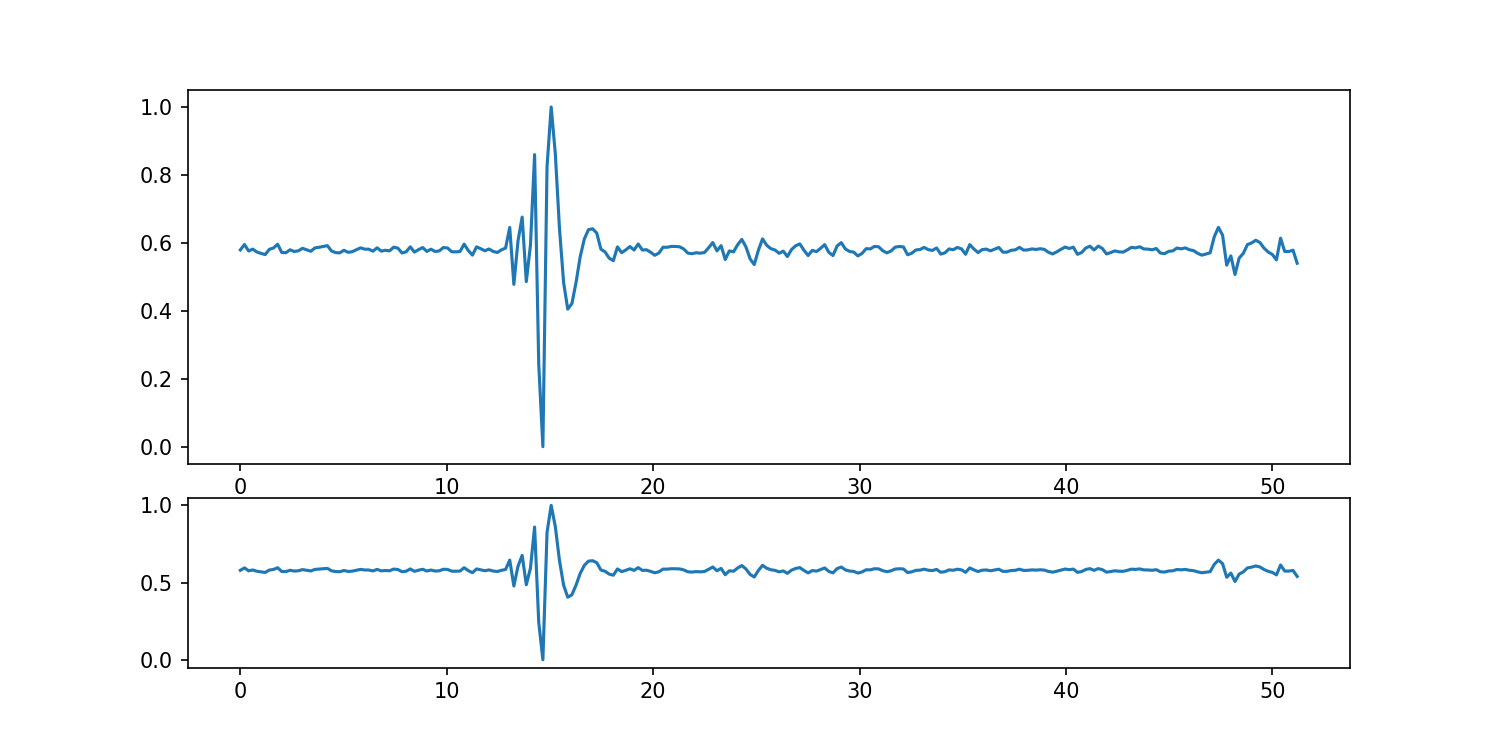

In [96]:
id = 0
dt = 1./5.
data_size = X_training.shape[1]
times = np.linspace(0., data_size*dt, data_size)

fig = plt.figure(figsize=(10,5))
grid = fig.add_gridspec(3, 1)

ax = fig.add_subplot(grid[:2, 0])
ax.plot(times, X_training[id,:,0])
#ax.plot(times, X_training[id,:,1])
#ax.plot(times, labels_training[id,:,0])

ax = fig.add_subplot(grid[2, 0])
ax.plot(times, labels_training[id,:,0])

In [5]:
import keras
from keras import layers

In [110]:
#filters = [4, 8, 16, 32]
#kernelsizes = [7, 7, 7, 7]
filters = [64, 128]
kernelsizes = [3, 3]
#filters = [32, 32, 32]
#kernelsizes = [3, 3, 3]
pooling_length = 2
dropout_rate = 0.
input_img = keras.Input(shape=X_training[0,:,:1].shape)

x = layers.Conv1D(filters[0], kernelsizes[0], activation='relu', padding='same')(input_img)
x = layers.Dropout(dropout_rate)(x)
x = layers.MaxPooling1D(pooling_length, padding='same')(x)
skips = [x]
for one_filter, one_kernel in zip(filters[1:], kernelsizes[1:]): 
    x = layers.Conv1D(one_filter, one_kernel, activation='relu', padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling1D(pooling_length, padding='same')(x)
    skips.append(x)

encoded = x
    
skips = skips[:-1]
x = layers.Conv1D(filters[-1], kernelsizes[-1], activation='relu', padding='same')(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.UpSampling1D(pooling_length)(x)
for one_filter, one_kernel in zip(filters[::-1][1:], kernelsizes[::-1][1:]):
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 1, activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 1)]          0         
                                                                 
 conv1d_66 (Conv1D)          (None, 256, 64)           256       
                                                                 
 dropout_56 (Dropout)        (None, 256, 64)           0         
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 128, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_67 (Conv1D)          (None, 128, 128)          24704     
                                                                 
 dropout_57 (Dropout)        (None, 128, 128)          0         
                                                          

In [111]:
autoencoder.fit(X_training[:,:,:1], labels_training[:,:,:1],
                epochs=20,
                batch_size=16,
                #shuffle=True,
                validation_data=(X_validation[:,:,:1], labels_validation[:,:,:1]),)
                #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/20
153/153 [==============================] - 5s 17ms/step - loss: 0.0196 - val_loss: 0.0140
Epoch 2/20
153/153 [==============================] - 2s 15ms/step - loss: 0.0141 - val_loss: 0.0128
Epoch 3/20
153/153 [==============================] - 2s 15ms/step - loss: 0.0137 - val_loss: 0.0126
Epoch 4/20
153/153 [==============================] - 2s 15ms/step - loss: 0.0135 - val_loss: 0.0125
Epoch 5/20
153/153 [==============================] - 2s 15ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 6/20
153/153 [==============================] - 2s 15ms/step - loss: 0.0134 - val_loss: 0.0124
Epoch 7/20
153/153 [==============================] - 2s 15ms/step - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
153/153 [==============================] - 2s 15ms/step - loss: 0.0133 - val_loss: 0.0124
Epoch 9/20
153/153 [==============================] - 2s 15ms/step - loss: 0.0133 - val_loss: 0.0124
Epoch 10/20
153/153 [==============================] - 2s 15ms/step - loss: 0.0133 - val_lo

In [112]:
#X_testing_loc = X_testing.copy()
X_testing_loc = X_training.copy()
dt=0.2
data_size = X_testing_loc.shape[1]
times = np.linspace(0., data_size*dt, data_size)
std = 5.
t0 = 40.
f0 = 2.
signal = np.exp(-((times-t0)/std)**2)*np.random.normal(-1,1,times.size)*0.1
signal = np.exp(-((times-t0)/std)**2)*np.sin(2 * np.pi * f0 * times)*0.
X_testing_loc[:,:,0] += np.expand_dims(signal, axis=0)
#predictions = autoencoder.predict(X_testing[:,:,:1])
#predictions_anomaly = autoencoder.predict(X_testing_loc[:,:,:1])
predictions = autoencoder.predict(X_training[:,:,:1])
predictions_anomaly = autoencoder.predict(X_testing_loc[:,:,:1])
#predictions_encoded = encoder.predict(X_testing_loc[:,:,:1])

77/77 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>


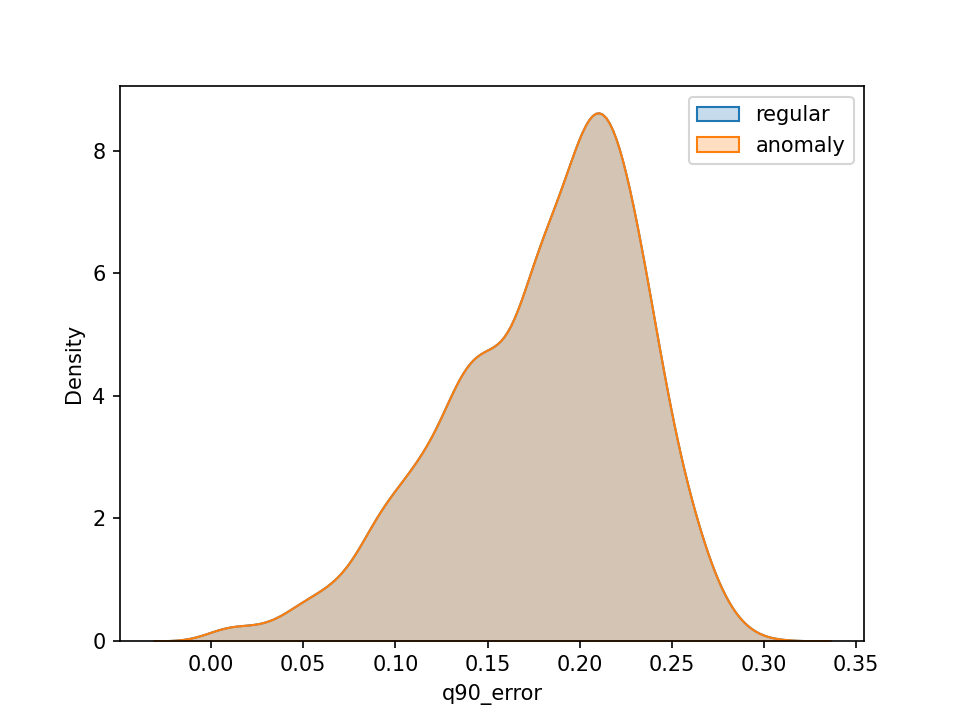

In [113]:
error=abs(predictions[:,:,0]-X_training[:,:,0])
error_anomaly=abs(predictions_anomaly[:,:,0]-X_testing_loc[:,:,0])
pd_error = pd.DataFrame()
pd_error['median_error'] = np.median(error, axis=-1)
pd_error['mean_error'] = np.mean(error, axis=-1)
pd_error['q90_error'] = np.quantile(error, q=0.9, axis=-1)
pd_error['median_error_anomaly'] = np.median(error_anomaly, axis=-1)
pd_error['mean_error_anomaly'] = np.mean(error_anomaly, axis=-1)
pd_error['q90_error_anomaly'] = np.quantile(error_anomaly, q=0.9, axis=-1)
plt.figure()
sns.kdeplot(data=pd_error, x='q90_error', fill=True, label='regular')
sns.kdeplot(data=pd_error, x='q90_error_anomaly', fill=True, label='anomaly')
plt.legend()

<IPython.core.display.Javascript object>


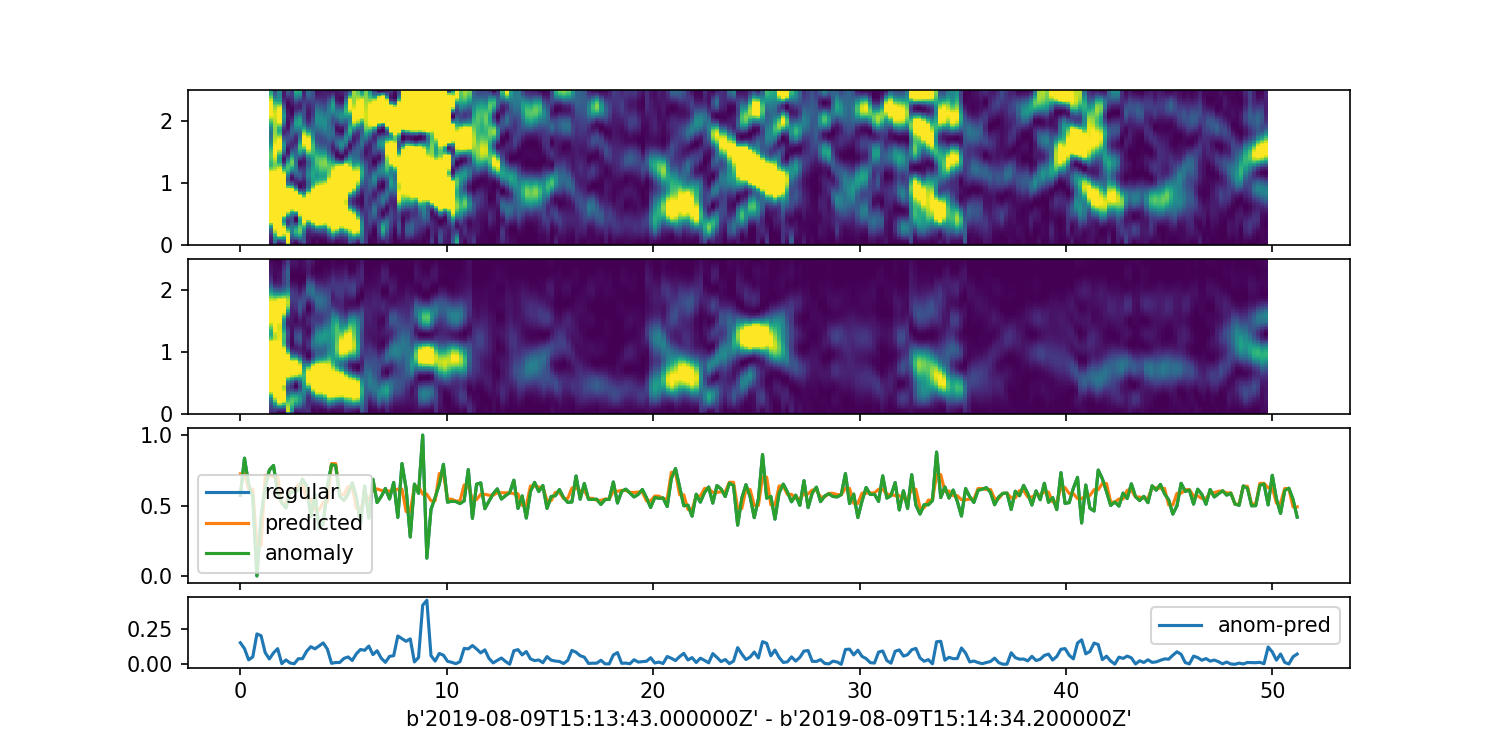

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


<IPython.core.display.Javascript object>


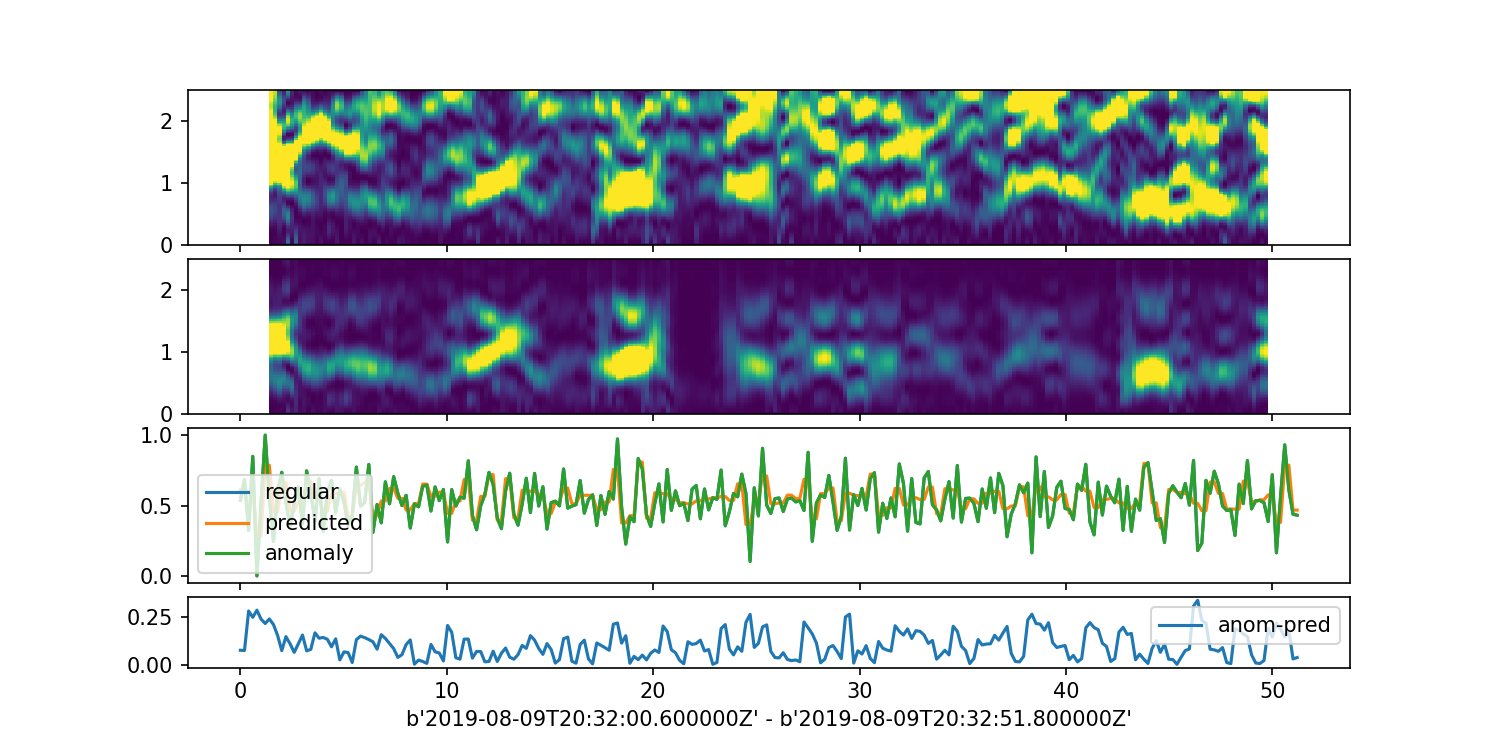

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


<IPython.core.display.Javascript object>


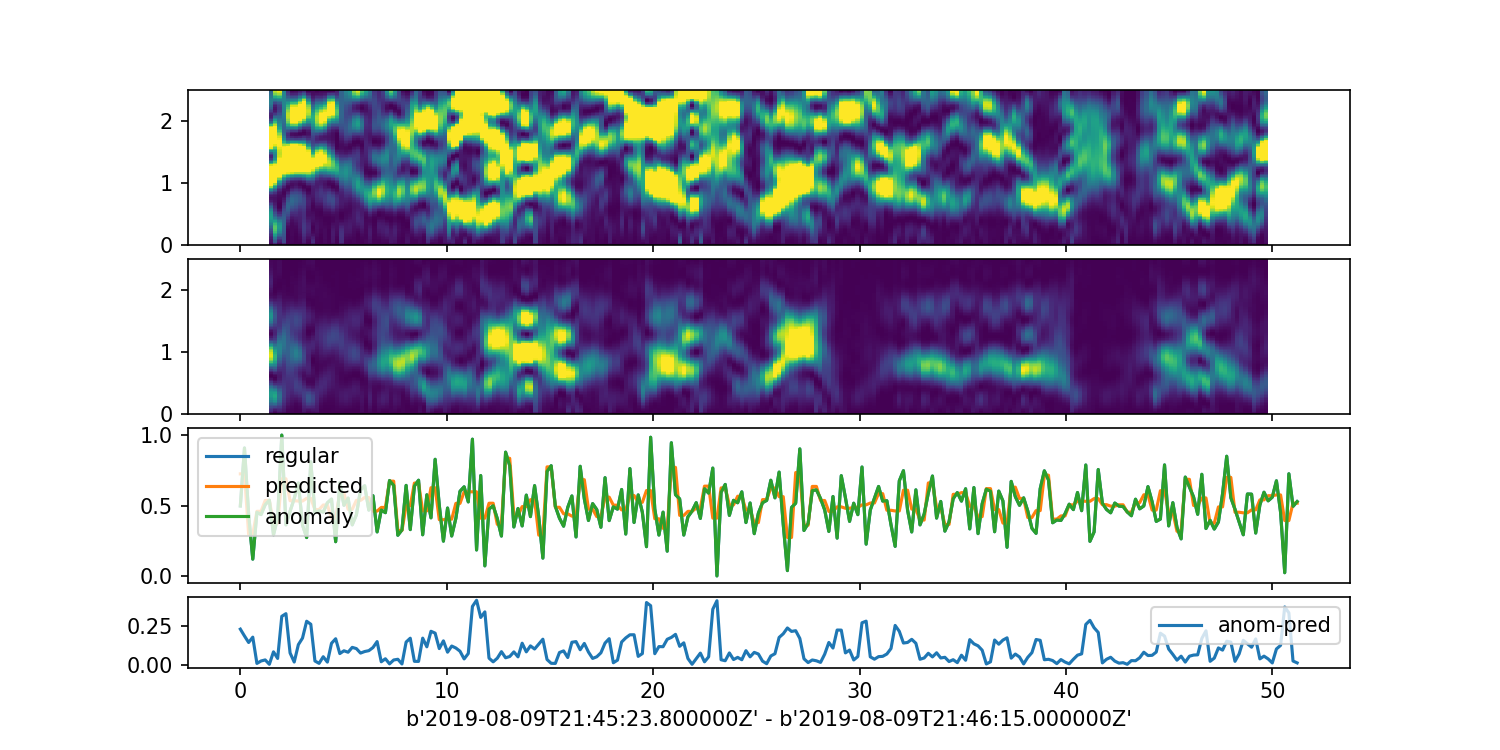

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


<IPython.core.display.Javascript object>


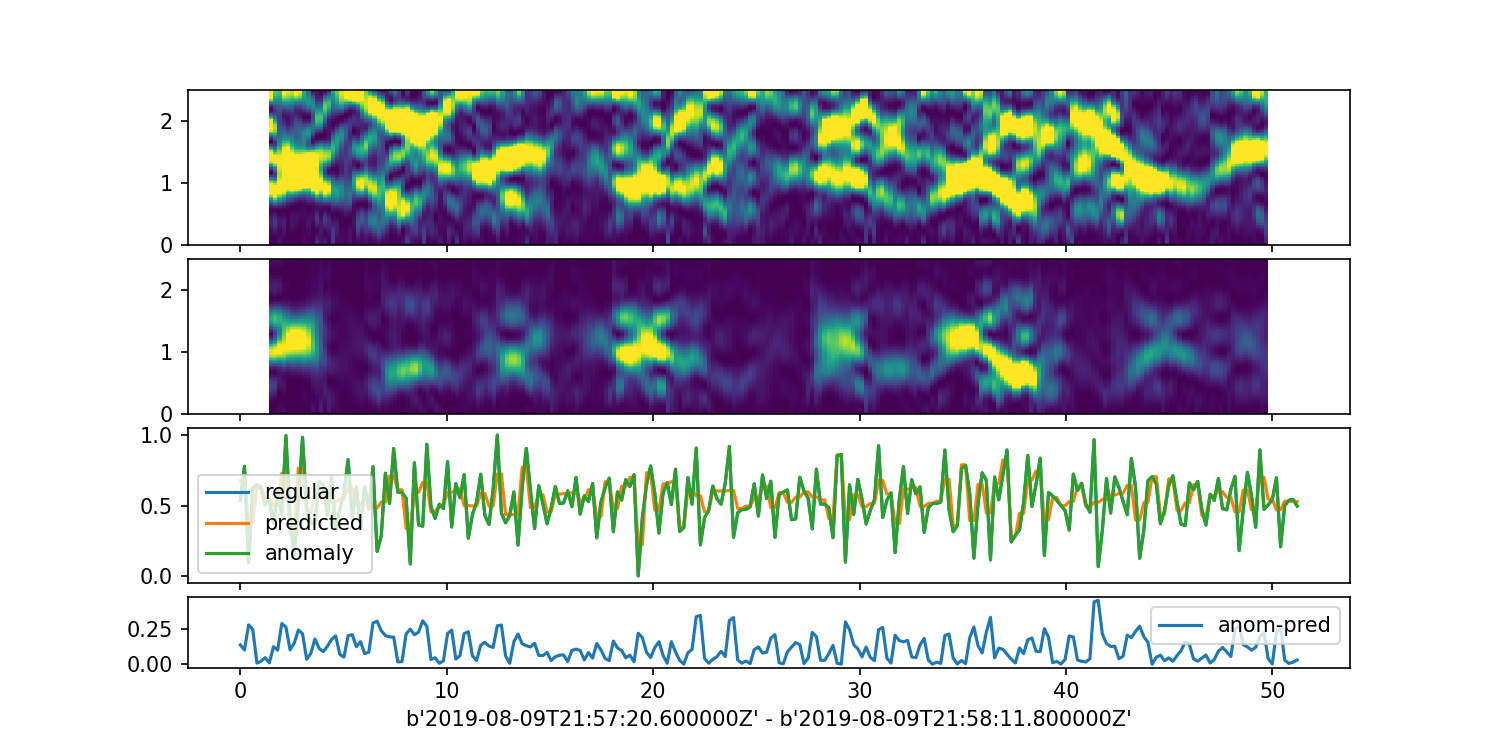

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [114]:
from scipy import signal
#def add_spectro(amp, dt, ax, nperseg=40, noverlap=39, nfft=200):
#    f, t, Sxx = signal.spectrogram(amp, 1./df, nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling='spectrum')
#    return 
def plot_one_item(id, windows, X, predictions, X_loc=np.array([]), dt=0.2, nperseg=14, noverlap=13, nfft=200):

    data_size = X.shape[1]
    times = np.linspace(0., data_size*dt, data_size)

    h_plot = 2
    fig = plt.figure(figsize=(10,5))
    grid = fig.add_gridspec(h_plot*3+1, 1)

    q_vmax = 0.9
    ax = fig.add_subplot(grid[:h_plot, 0])
    if X_loc.shape[0]>0:
        f, t, Sxx = signal.spectrogram(X_loc[id,:,0], 1./dt, nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling='spectrum')
    else:
        f, t, Sxx = signal.spectrogram(X[id,:,0], 1./dt, nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling='spectrum')
    vmax = np.quantile(abs(Sxx), q=q_vmax)
    ax.pcolormesh(t, f, abs(Sxx), vmax=vmax)
    
    ax = fig.add_subplot(grid[h_plot:2*h_plot, 0], sharex=ax)
    f, t, Sxx = signal.spectrogram(predictions[id,:,0], 1./dt, nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling='spectrum')
    ax.pcolormesh(t, f, abs(Sxx), vmax=vmax)
    
    
    ax = fig.add_subplot(grid[2*h_plot:-1, 0], sharex=ax)
    ax.plot(times, X[id,:,0], label='regular')
    ax.plot(times, predictions[id,:,0], label='predicted')
    if X_loc.shape[0]>0:
        ax.plot(times, X_loc[id,:,0], label='anomaly')
    ax.legend()
    
    ax = fig.add_subplot(grid[-1, 0])
    
    if X_loc.shape[0]>0:
        ax.plot(times, abs(X_loc[id,:,0]-predictions[id,:,0]), label='anom-pred')
    else:
        ax.plot(times, abs(X[id,:,0]-predictions[id,:,0]), label='reg-pred')
    #ax.axhline(0.25, color='red', linestyle=':')
    ax.legend()
    ax.set_xlabel(str(windows[id, 0])+' - ' + str(windows[id, 1]))
for id in [100, 300, 386, 400]:
    #plot_one_item(id, windows_testing, labels_testing, predictions_anomaly, X_loc=X_testing_loc, dt=0.2) 
    plot_one_item(id, windows_training, labels_training, predictions_anomaly, X_loc=X_testing_loc, dt=0.2)   

In [6]:
from nais.Models import PhaseNet

No module named 'kapre'
kapre not installed
No module named 'kapre'
kapre not installed


In [19]:
filters = [4, 8, 16, 32]
#filters = [32,64,128,256]
kernelsizes = [7, 7, 7, 7]
model = PhaseNet(num_classes=1, output_activation='sigmoid', filters=filters, kernelsizes=kernelsizes, dropout_rate=0.4)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
#class_weight = {0: 0.1, 1: 0.9}
model.fit(X_training, 
          labels_training,
          validation_data=(X_validation, labels_validation),
          epochs=16,)

Epoch 1/16
35/35 [==============================] - 11s 62ms/step - loss: nan - val_loss: nan
Epoch 2/16
35/35 [==============================] - 1s 35ms/step - loss: nan - val_loss: nan
Epoch 3/16
35/35 [==============================] - 1s 34ms/step - loss: nan - val_loss: nan
Epoch 4/16
35/35 [==============================] - 1s 34ms/step - loss: nan - val_loss: nan
Epoch 5/16
35/35 [==============================] - 1s 34ms/step - loss: nan - val_loss: nan
Epoch 6/16
35/35 [==============================] - 1s 33ms/step - loss: nan - val_loss: nan
Epoch 7/16
35/35 [==============================] - 1s 34ms/step - loss: nan - val_loss: nan
Epoch 8/16
35/35 [==============================] - 1s 34ms/step - loss: nan - val_loss: nan
Epoch 9/16
35/35 [==============================] - 1s 34ms/step - loss: nan - val_loss: nan
Epoch 10/16
35/35 [==============================] - 1s 34ms/step - loss: nan - val_loss: nan
Epoch 11/16
35/35 [==============================] - 1s 34ms/step - 

In [ ]:
timesteps = ...  # Length of your sequences
input_dim = ... 
latent_dim = ...

inputs = keras.Input(shape=(timesteps, input_dim))
encoded = layers.LSTM(latent_dim)(inputs)

decoded = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = keras.Model(inputs, decoded)
encoder = keras.Model(inputs, encoded)